Packages

In [25]:
import pandas as pd
import numpy as np
from numpy import percentile

import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

import scipy.stats as stats
from scipy.stats import shapiro

Loading data

In [26]:
df = pd.read_csv('cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


# Srubbing

- Missing values (There's no missing values)
- Duplicates
- Outliers

## Duplicates

Check duplicates row & userid

In [28]:
print(df.duplicated().any())
print(df['userid'].duplicated().any())

False
False


## Outliers

Summary stats of game rounds by version

In [29]:
df_30 = df[df.version == 'gate_30']
df_40 = df[df.version == 'gate_40']

stat_all = df[['sum_gamerounds']].describe([0.01, 0.05, 0.10, 0.25, 0.75, 0.90, 0.95, 0.99]).T
stat_30 = df_30[['sum_gamerounds']].describe([0.01, 0.05, 0.10, 0.25, 0.75, 0.90, 0.95, 0.99]).T
stat_40 = df_40[['sum_gamerounds']].describe([0.01, 0.05, 0.10, 0.25, 0.75, 0.90, 0.95, 0.99]).T

summary_stats = pd.concat([stat_all,stat_30,stat_40], keys=["stat_all", "stat_30", "stat_40"])
summary_stats

,,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
stat_all,sum_gamerounds,90189.0,51.872457,195.050858,0.0,0.0,1.0,1.0,5.0,16.0,51.0,134.0,221.0,493.00,49854.0
stat_30,sum_gamerounds,44700.0,52.456264,256.716423,0.0,0.0,1.0,1.0,5.0,17.0,50.0,135.0,222.0,493.00,49854.0
stat_40,sum_gamerounds,45489.0,51.298776,103.294416,0.0,0.0,1.0,1.0,5.0,16.0,52.0,134.0,220.0,492.12,2640.0


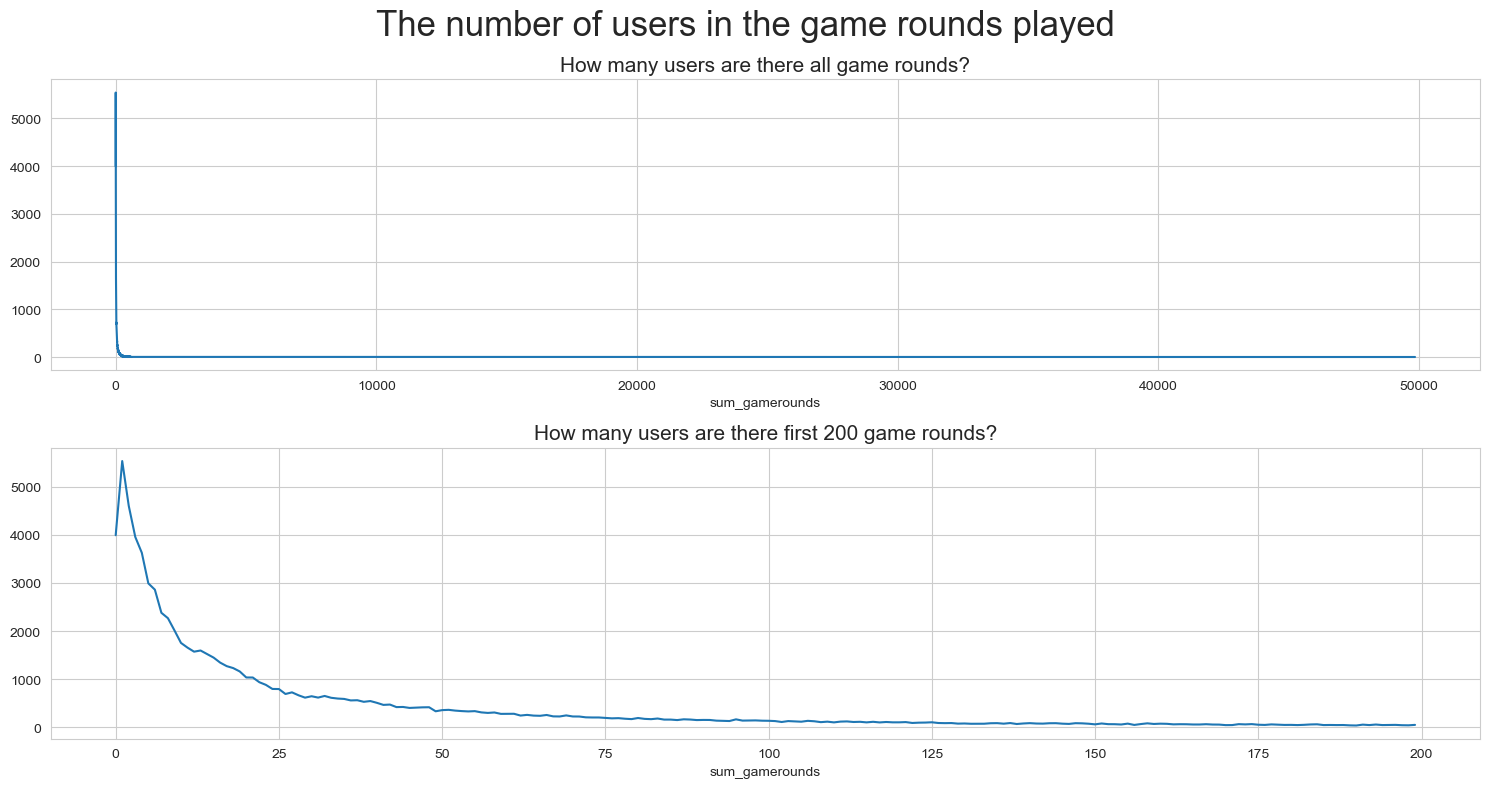

In [30]:
fig, axes = plt.subplots(2, 1, figsize = (15,8))
df.groupby("sum_gamerounds").userid.count().plot(ax = axes[0])
df.groupby("sum_gamerounds").userid.count()[:200].plot(ax = axes[1])
plt.suptitle("The number of users in the game rounds played", fontsize = 25)
axes[0].set_title("How many users are there all game rounds?", fontsize = 15)
axes[1].set_title("How many users are there first 200 game rounds?", fontsize = 15)
plt.tight_layout();

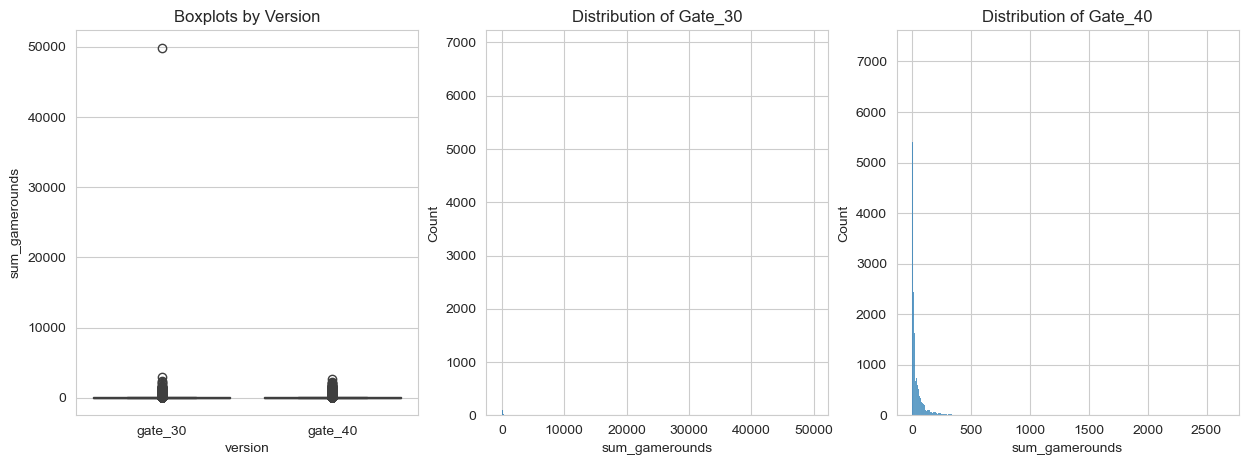

In [31]:
fig, axes = plt.subplots(1,3)

sns.boxplot(x=df.version, y=df.sum_gamerounds, ax=axes[0])
axes[0].set_title("Boxplots by Version")

sns.histplot(x="sum_gamerounds", data=df_30, ax=axes[1])
axes[1].set_title("Distribution of Gate_30")

sns.histplot(x="sum_gamerounds", data=df_40,ax=axes[2])
axes[2].set_title("Distribution of Gate_40")

plt.show()

We notice that the distribution of the sum_gamerounds is exponential-like, which centers in a small range with with a long right tail. About 50% of the total sum_gamerounds is the values between 5 and around 51. As the values of the sum_gamerounds increase, the counts descrease dramatically. The values of the last 5 percent and 1 percent of the data are respectively larger than 221 and 493. How we choose the cutoff of the outliers might affect our test result.

### Detecting and handling outliers

1. Standard Deviation method: used for Gaussian or Gaussian-like data. One standard deviation (std) from the mean will cover 68%, two std from the the mean will cover 95%, and three std from the mean will cover 99.7%. Three std from the mean is a common cut-off in practice for identifying outliers in a Gaussian or Gaussian-like distribution. For smaller samples of data, perhaps a value of 2 std can be used, and for larger samples, perhaps a value of 4 std can be used.

2. Interquatile Range Method (IQR): used for a non-Gaussian distribution. The IQR can then be calculated as the difference between the 75th and 25th percentiles. A factor k of the IQR below 25th percentile or above the 75th percentile is used to identify outliers. The common value for the factor k is the value 1.5. A factor k of 3 or more can be used to identify values that are extreme outliers.

Since the distribution is exponential-like, we will use IQR method.

In [32]:
def handle_outliers(dataframe, col): 
    q25, q75 = percentile(dataframe[col], 25), percentile(dataframe[col],75)
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr*4
    lower = q25 - cut_off
    upper = q75 + cut_off
    print("25th=%d, 75th=%d, IQR=%d, Lower=%d, Upper=%d" % (q25, q75, iqr, lower, upper))
    # identify outliers
    outliers = dataframe[(dataframe[col] < lower)|(dataframe[col] > upper)]
    print('The number of identified outliers: %d' % len(outliers))
    outliers_removed = dataframe[(dataframe[col] >= lower) & (dataframe[col] <= upper)]
    print('Pct of outliers: %.2f%%' % (100*len(outliers)/len(dataframe)))
    
    return outliers_removed

In [33]:
handle_outliers(df, 'sum_gamerounds')

25th=5, 75th=51, IQR=46, Lower=-179, Upper=235
The number of identified outliers: 4073
Pct of outliers: 4.52%


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


In this case, IQR method is not very well. Therefore, it is better for us to list all of the testing results with the relevant outlier percentage. Then the product development team can make a decision depending on their concern.

In [34]:
df_cleaned = handle_outliers(df, 'sum_gamerounds')

25th=5, 75th=51, IQR=46, Lower=-179, Upper=235
The number of identified outliers: 4073
Pct of outliers: 4.52%


In [35]:
df_30_cleaned = df_cleaned[df_cleaned.version == 'gate_30']
df_40_cleaned = df_cleaned[df_cleaned.version == 'gate_40']

stat_all_cleaned = df_cleaned[['sum_gamerounds']].describe([0.01, 0.05, 0.10, 0.25, 0.75, 0.90, 0.95, 0.99]).T
stat_30_cleaned = df_30_cleaned[['sum_gamerounds']].describe([0.01, 0.05, 0.10, 0.25, 0.75, 0.90, 0.95, 0.99]).T
stat_40_cleaned = df_40_cleaned[['sum_gamerounds']].describe([0.01, 0.05, 0.10, 0.25, 0.75, 0.90, 0.95, 0.99]).T

summary_stats_cleaned = pd.concat([stat_all_cleaned,stat_30_cleaned,stat_40_cleaned], keys=["stat_all_cleaned", "stat_30_cleaned", "stat_40_cleaned"])
summary_stats_cleaned

,,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
stat_all_cleaned,sum_gamerounds,86116.0,34.098112,46.004866,0.0,0.0,1.0,1.0,4.0,15.0,43.0,98.0,143.0,208.0,235.0
stat_30_cleaned,sum_gamerounds,42666.0,34.096822,45.898627,0.0,0.0,1.0,1.0,5.0,15.0,43.0,98.0,143.0,209.0,235.0
stat_40_cleaned,sum_gamerounds,43450.0,34.099379,46.109477,0.0,0.0,1.0,1.0,4.0,15.0,44.0,99.0,143.0,208.0,235.0


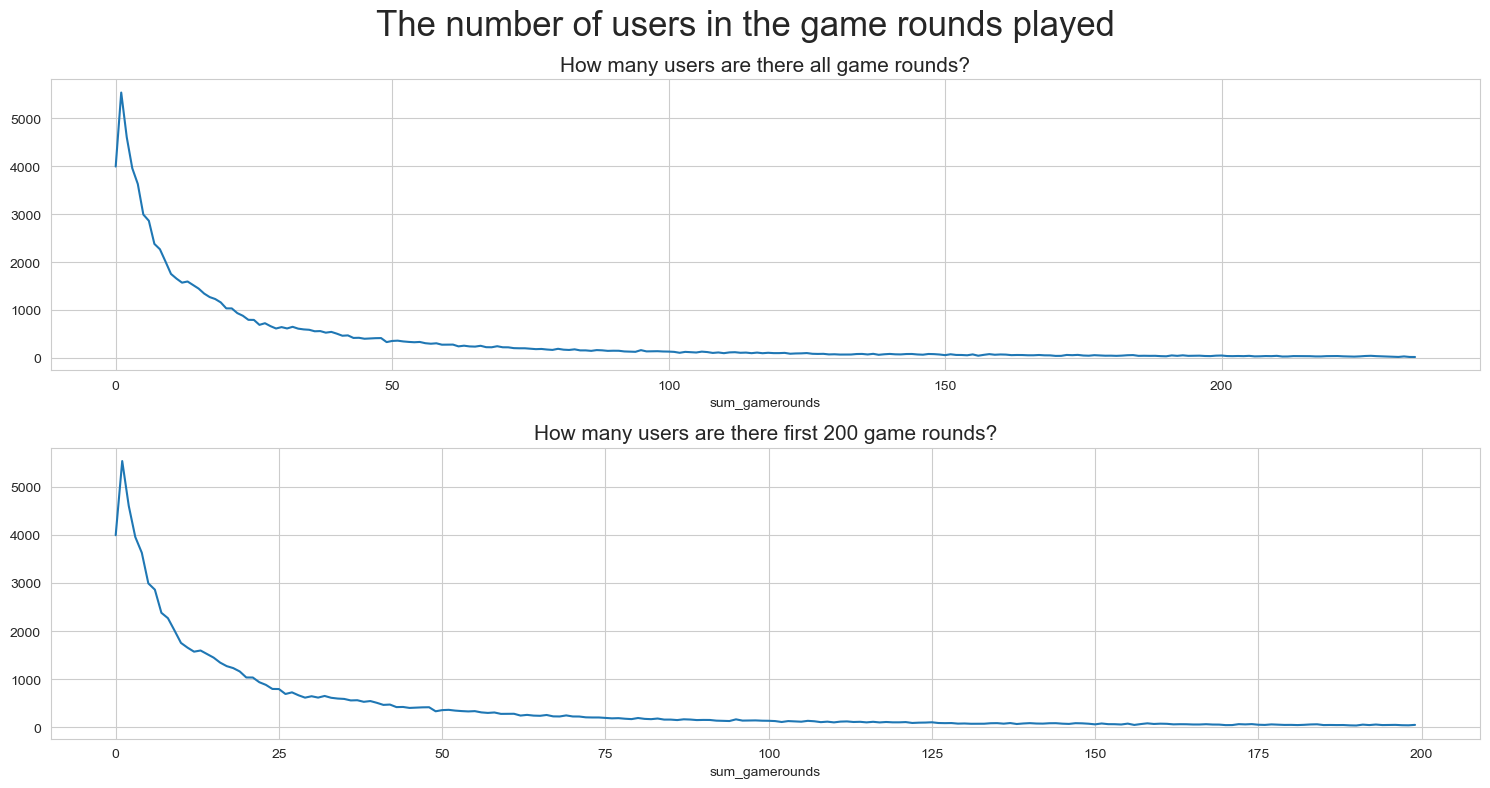

In [36]:
fig, axes = plt.subplots(2, 1, figsize = (15,8))
df_cleaned.groupby("sum_gamerounds").userid.count().plot(ax = axes[0])
df_cleaned.groupby("sum_gamerounds").userid.count()[:200].plot(ax = axes[1])
plt.suptitle("The number of users in the game rounds played", fontsize = 25)
axes[0].set_title("How many users are there all game rounds?", fontsize = 15)
axes[1].set_title("How many users are there first 200 game rounds?", fontsize = 15)
plt.tight_layout();

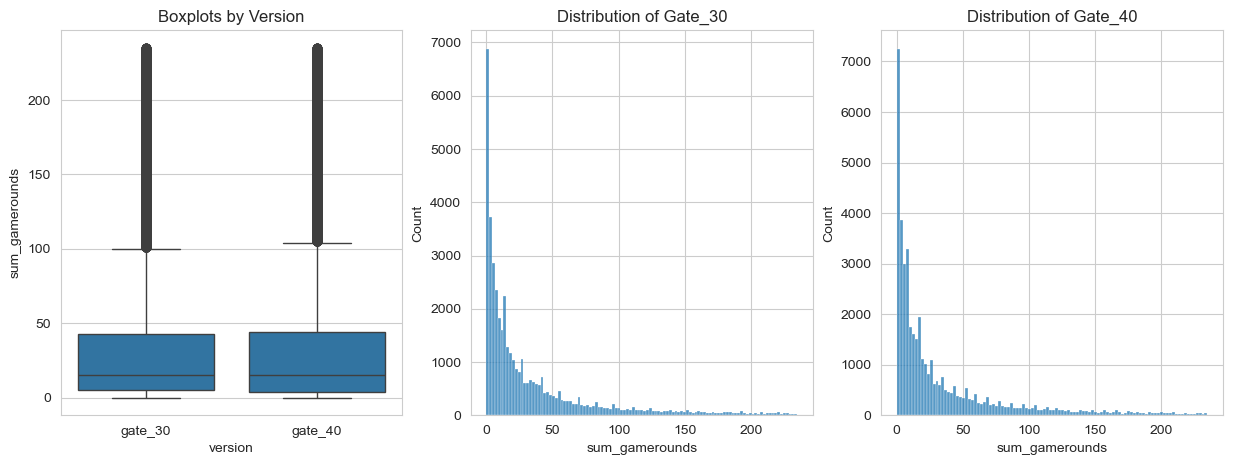

In [37]:
fig, axes = plt.subplots(1,3)

sns.boxplot(x=df_cleaned.version, y=df_cleaned.sum_gamerounds, ax=axes[0])
axes[0].set_title("Boxplots by Version")

sns.histplot(x="sum_gamerounds", data=df_30_cleaned, ax=axes[1])
axes[1].set_title("Distribution of Gate_30")

sns.histplot(x="sum_gamerounds", data=df_40_cleaned,ax=axes[2])
axes[2].set_title("Distribution of Gate_40")

plt.show()

# A/B Testing

## A/B Testing on Continuous Variables: sum_gamerounds

**Assumptions:**
- Check normality
- If normal distribution, check homogeneity

**Steps:**
1. Split & define Control group and Test group
    - The Control group is the baseline group that does not receives any changes or new treatments. It experiences the current version (A).
    - The Test group is the group that receives the new variation (B) which experiences the change or feature being tested.
    - The split should be random and ideally ensure both groups are comparable in terms of characteristics (e.g., age, gender, user type) so that any observed differences in outcome can be attributed to the change rather than underlying factors.

2. Apply Shapiro-Wilk test for normality
    - The Shapiro-Wilk test is used to check whether you data follows a normal distribution. A normal distribution is important for certain statistical tests (parametric tests).
    - If the test result (p-value) is greater than a chosen significant level (usually 0.05), we can assume that the data is normally distributed.
    - If the result is below the significant level, the data is nor normally distributed, then we need to use non-parametric tests.

3. If parametric (normal distribution) + homogeneity of variances, apply T-test
    - Parametric means that the data follows a normal distribution.
    - Homogeneity of variances means that both the control and test groups have similar variance.
    - If both conditions are met, you can apply a T-test to compare the means of the two groups. This test checks if there is a significant difference between the averages of the control and test groups.

4. If parametric - homogeneity of variances, apply Welch test
    - If the data is normally distributed but the variances of the two groups are not equal, then use the Welch test instead of the T-test.
    - The Welch test (or Welch's t-test) is a variation of the standard t-test. It is used when two groups have unequal variances (i.e., the spread of data points in each group is different) and/or unequal sample sizes.
    <!-- - The Welch test adjust for differences in variance and provides a more accurate result when variances are unequal. -->

5. If non-parametric, apply Mann-Whitney U test directly
    - If the data is not normally distributed, then use a non-parametric test, which does not assume normality.
    - The Mann-Whitney U test is used in this case. It compares the rankings of the values in the two groups instead of comparing their means. This is helpful when the data is skewed or does not follow a normal distribution.

A/B Testing Hypothesis:
- H0: A == B: There is no statistical difference between the gate_30 and the gate_40
- H1: A != B: There is statistical difference between the gate_30 and the gate_40

In [38]:
# A/B testing function for continuous variables
def AB_test_continuous(dataframe, group, target, A, B):
    # packages (already imported above)
    # from scipy.stats import shapiro
    # import scipy.stats as stats

    # split A/B
    groupA = dataframe[dataframe[group] == A][target]
    groupB = dataframe[dataframe[group] == B][target]

    # assumption: normality
    ntA = shapiro(groupA)[1] < 0.05 # -> reject H0
    ntB = shapiro(groupB)[1] < 0.05
        # H0: Distribution is normal - False
        # H1: Distribution is not normal - True
    if (ntA == False)&(ntB == False): 
        # parametric test
        # assumption: homogeneity of variances
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
            # H0: Homogeneity - False
            # H1: Heterogeneous - True
        if leveneTest == False:
            # homogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
                # H0: M1 == M2 - False
                # H1: M1 != M2 - True
        else:
            # heterogenerous
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
                # H0: M1 == M2 - False
                # H1: M1 != M2 - True
    else:
        # non-parametric test
        ttest = stats.mannwhitneyu(groupA, groupB)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    # result
    temp = pd.DataFrame({
        'AB Hypothesis': [ttest < 0.05],
        'p-value':[ttest]
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    # columns
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity", "AB Hypothesis", "p-value", "Comment"]]
    else:
        temp = temp[["Test Type", "AB Hypothesis", "p-value", "Comment"]]
    # print hypothesis
    print("A/B Testing Hypothesis:")
    print("H0: A == B")
    print("H1: A != B", "\n")
    return temp

In [39]:
AB_test_continuous(dataframe=df_cleaned, group='version', target='sum_gamerounds', A='gate_30', B='gate_40')

A/B Testing Hypothesis:
H0: A == B
H1: A != B 



,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Fail to Reject H0,0.056657,A/B groups are similar!


## A/B Testing on Discrete Variables: retention_1, retention_7

In [40]:
# A/B Testing on discrete metrics
def AB_test_discrete(dataframe, group, metric, A, B):
    
    # Split groups
    group_c = dataframe[dataframe[group] == A][metric]
    group_t = dataframe[dataframe[group] == B][metric]
    
    size = dataframe.shape[0]  
    table = pd.DataFrame({"C_COUNT": group_c.value_counts(),
              "T_COUNT": group_t.value_counts()}).to_numpy()
    
    if size < 1000:
        # Fisher Exact Test
        odd_ratio, p_value = stats.fisher_exact(table, alternative="two-sided")
    else:
        # Pearson Chi Square Test
        stat, p_value, dof, expected = stats.chi2_contingency(table)
    # Result
    temp = pd.DataFrame({
        "Test":[size<1000],
        "P_value":[p_value],
        "AB Hypothesis":[p_value < 0.05], 
    })
    temp["Test"] = np.where(temp["Test"]==True, "Fisher Exact Test", "Chi Square Test")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    
    return temp

In [41]:
AB_test_discrete(dataframe=df_cleaned, group = "version", metric = "retention_1", A='gate_30', B='gate_40')

,Test,P_value,AB Hypothesis,Comment
0,Chi Square Test,0.096855,Fail to Reject H0,A/B groups are similar!


In [42]:
AB_test_discrete(dataframe=df_cleaned, group = "version", metric = "retention_7", A='gate_30', B='gate_40')

,Test,P_value,AB Hypothesis,Comment
0,Chi Square Test,0.00068,Reject H0,A/B groups are not similar!


In [43]:
# gate_30 retention rates
pd.DataFrame({"RET1_COUNT": df_30_cleaned["retention_1"].value_counts(),
              "RET7_COUNT": df_30_cleaned["retention_7"].value_counts(),
              "RET1_RATIO": df_30_cleaned["retention_1"].value_counts()*100 / len(df_30_cleaned),
              "RET7_RATIO": df_30_cleaned["retention_7"].value_counts()*100 / len(df_30_cleaned)})

,RET1_COUNT,RET7_COUNT,RET1_RATIO,RET7_RATIO
False,24554,35941,57.549337,84.238035
True,18112,6725,42.450663,15.761965


In [44]:
# gate_40 retention rates
pd.DataFrame({"RET1_COUNT": df_40_cleaned["retention_1"].value_counts(),
              "RET7_COUNT": df_40_cleaned["retention_7"].value_counts(),
              "RET1_RATIO": df_40_cleaned["retention_1"].value_counts()*100 / len(df_40_cleaned),
              "RET7_RATIO": df_40_cleaned["retention_7"].value_counts()*100 / len(df_40_cleaned)})

,RET1_COUNT,RET7_COUNT,RET1_RATIO,RET7_RATIO
False,25249,36965,58.110472,85.074799
True,18201,6485,41.889528,14.925201


# Interpreting

**Remind the business problem:**

As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. In this project, we will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on player retention and game rounds.

**After applying A/B Testing, the results gives us some important information:**
- The Mann Whitney U test failed to reject H0 hypothesis and we learned that A/B groups are similar. Therefore, there's no statistically significant difference in number of game rounds between version gate_30 and gate_40.
- The Chi Square test's results helped us learn that version gate_30 and gate_40 are similar in term of retention_1 but are statistically different in term of retention_7. The retention_7 rate of version gate_40 is 14,92% that is lower than 15,76% of version gate_30.

**Hence, we should keep the old version.**
- This outcome suggests that changing the first gate from level 30 to level 40 may not influence number of game rounds and retention 1 day after installing. However, the retention rates 7 day after installing after the change decreased which is counter-intuitive. 
- It's essential to continue to consider other potential factors that may influence player behavior, such as the overall game experience, the presence of alternative options, and the quality of in-game rewards.